In [1]:
import numpy as np
import pandas as pd
import hist
from hist import Hist
import awkward as ak
import json
import uproot

import matplotlib.pyplot as plt
import mplhep
plt.style.use(mplhep.style.CMS)

In [6]:
json_dir = "inputfiles/2022/Hbb"
out_dir = "outfiles"

# Samples

* [Hto2B](#hbb)
* [QCD](#qcd)

# Hto2B sample <a class="anchor" id="hbb"></a>

In [3]:
from coffea.nanoevents import NanoEventsFactory, ScoutingNanoAODSchema, ScoutingJMENanoAODSchema, BaseSchema
from coffea import processor, util
from collections import defaultdict

In [4]:
class Processor(processor.ProcessorABC):
    def __init__(self):
        pass

    def process(self, events):
        
        dataset = events.metadata['dataset']
        output = defaultdict()
        output["nevents"] = {
            dataset : len(events),
        }
        
        h = Hist(
            hist.axis.Variable([-0.1, 0.8167194, 0.95448214, 0.9864132, 1.1], name="disc", label=r"$H\rightarrow b\bar{b}$ vs QCD discriminator"),
            hist.axis.Regular(30, -0.1, 200, name="msd", label=r"$m_{SD}$"),
            hist.axis.Regular(30, 0, 200, name="reg", label=r"Regressed mass"),
            hist.axis.Boolean(name="match"),
            hist.axis.Regular(36, 200, 2000, name="pt", label=r"$p_T"),
            hist.axis.StrCategory([], name="dataset", label="Dataset", growth=True),
        )
        
        def normalise(arr):
            return ak.to_numpy(ak.fill_none(arr, np.nan))

        def hbb_disc(sig, bkg):
            return ak.where((sig + bkg == 0), 0, sig / (sig + bkg))
        
        fatjets = events.ScoutingFatJet
        fatjets = fatjets[
            (fatjets.pt > 200) &
            (fatjets.pt < 2000) &
            (fatjets.msoftdrop < 260) &
            (abs(fatjets.eta) < 2.5)
        ]
        fatjet = ak.firsts(fatjets)

        # get Higgs
        H = events.GenPart[
            (abs(events.GenPart.pdgId) == 25)
            & (events.GenPart.hasFlags(['fromHardProcess', 'isLastCopy']))
        ]

        # get b quarks
        b_H = ak.flatten(H.children)

        b_H_dr = fatjet.delta_r(b_H)
        index_descend_b_H = ak.argsort(b_H_dr, axis=1, ascending=False)
        b_H_dr_descend = b_H_dr[index_descend_b_H]

        # is fatjet matched to b quarks?
        is_fatjet_b_H = ak.firsts(b_H_dr_descend, axis=1) < 0.8
        
        disc = hbb_disc(
            fatjet.particleNet_prob_Hbb,
            fatjet.particleNet_prob_QCD
        )

        h.fill(
            disc = normalise(disc),
            msd = normalise(fatjet.msoftdrop),
            reg = normalise(fatjet.particleNet_mass),
            pt = normalise(fatjet.pt),
            match = normalise(is_fatjet_b_H),
            dataset = dataset,
        )
        
        output["h"] = h

        return output

    def postprocess(self, accumulator):
        pass

In [19]:
fileset = {}
with open(f"{json_dir}/GluGluHto2B.json") as fin:
    fileset = json.load(fin)

futures_run = processor.Runner(
    executor = processor.FuturesExecutor(compression=None, workers=2),
    schema=ScoutingNanoAODSchema,
)

output = futures_run(
    fileset,
    "Events",
    processor_instance=Processor()
)

util.save(output, "outfiles/2022/tagger/tagger_and_massreg_GluGluHto2B.coffea")

Output()

/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(
/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(


In [5]:
from lpcjobqueue import LPCCondorCluster
from distributed import Client

fileset = {}
with open(f"{json_dir}/Hto2B.json") as fin:
    fileset = json.load(fin)
    
cluster = LPCCondorCluster(ship_env=True)
cluster.adapt(minimum=0, maximum=100)
client = Client(cluster)

output, metrics = processor.run_uproot_job(
    fileset,
    "Events",
    Processor(),
    processor.dask_executor,
    {
        "client": client,
        # "align_clusters": True,
        "retries": 3,
        "schema": ScoutingNanoAODSchema,
        "savemetrics": True,
        "skipbadfiles": True,
    },
)

util.save(output, "outfiles/2022/tagger/tagger_and_massreg_Hto2B.coffea")

client.close()
cluster.close()

In [7]:
output = util.load(f"{out_dir}/tagger_and_massreg_Hto2B.coffea")

/tmp/ipykernel_1186/3159875338.py:26: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 4)
/tmp/ipykernel_1186/3159875338.py:26: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 4)


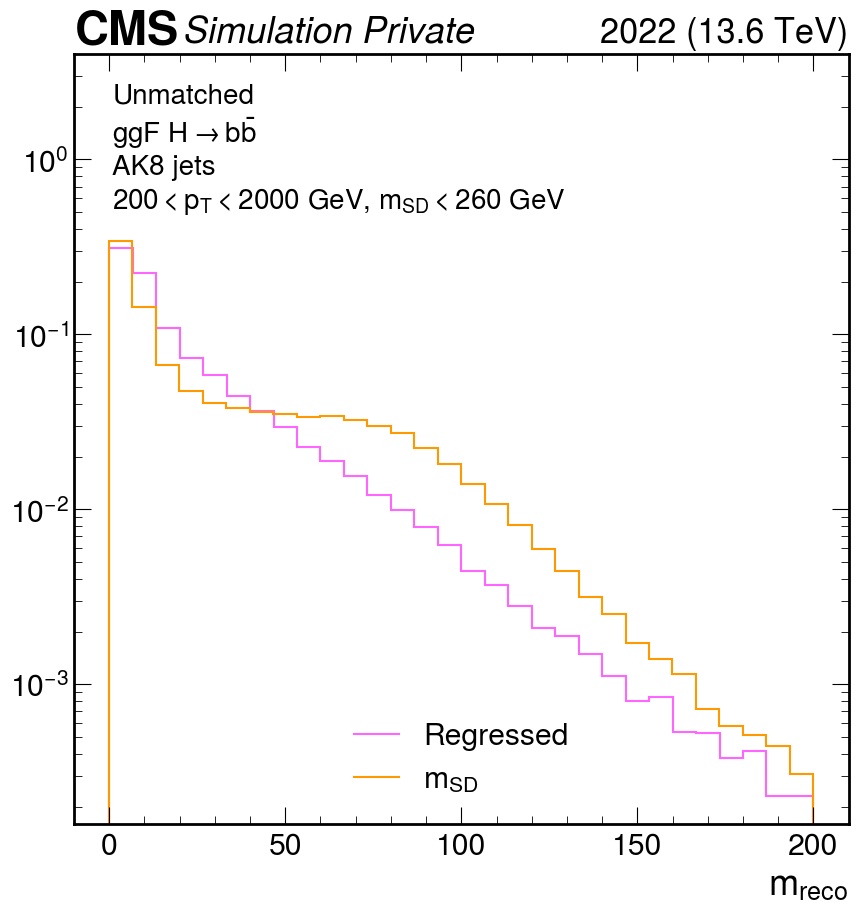

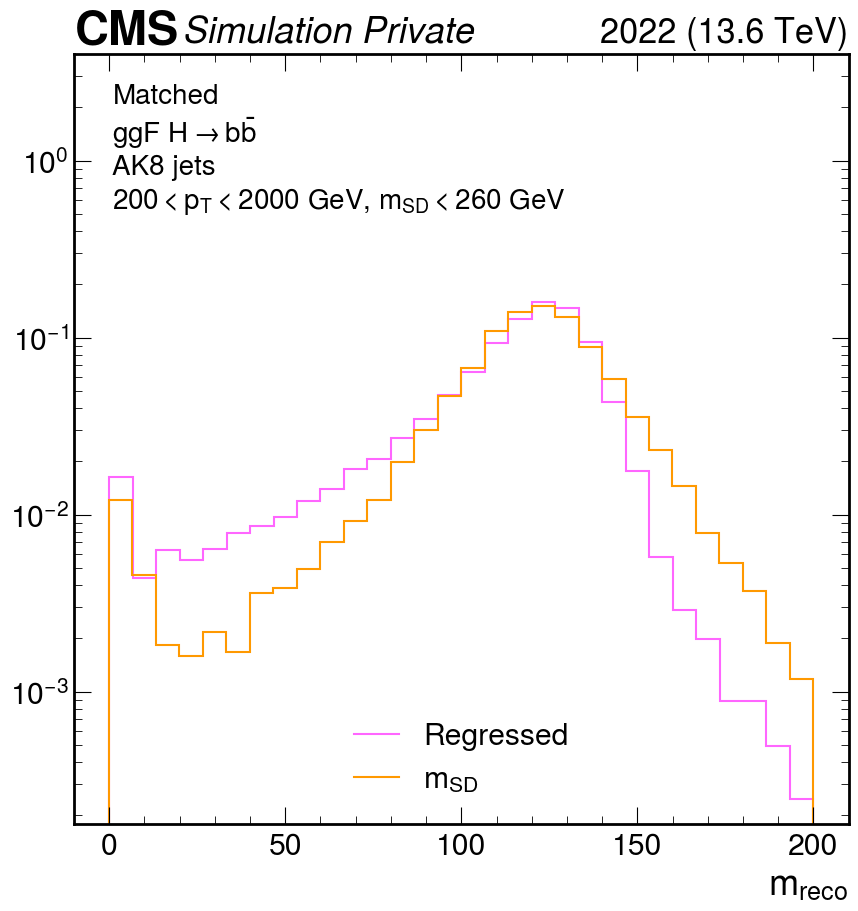

In [20]:
colours = {
    "hbb" : "#FF66FF",
    "qcd" : "#FF9900",
}

h = output["h"]

for events, match in [("Unmatched", 0), ("Matched", 1)]:
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    for mass in ["reg", "msd"]:

        h1 = h.project(mass, "match")[:, hist.loc(match)]
        n = h1.sum()
        h1 = h1 / n

        mplhep.histplot(h1, ax=ax,
                        label=r"$m_{SD}$" if "msd" in mass else "Regressed",
                        color=colours["qcd"] if "msd" in mass else colours["hbb"])

    
    ax.set_yscale('log')
    ax.set_xlabel(r"$m_{reco}$")
    ax.legend(loc="lower center")
    ax.set_ylim(0, 4)
              
    label = mplhep.cms.label(ax=ax, data=False, year="2022", com=13.6, label="Private")

    coffee = plt.text(0.05, 0.79, f"{events}\n" + r"ggF $H\rightarrow b\bar{b}$" + "\nAK8 jets\n" + r"$200 < p_T < 2000$ GeV, $m_{SD} < 260$ GeV",
                      fontsize=20,
                      horizontalalignment='left',
                      verticalalignment='bottom',
                      transform=ax.transAxes,
                     )
              
# fig.savefig("Disc.pdf", bbox_inches='tight', pad_inches=0.1)

/tmp/ipykernel_1186/3560589734.py:37: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 4)
/tmp/ipykernel_1186/3560589734.py:37: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 4)


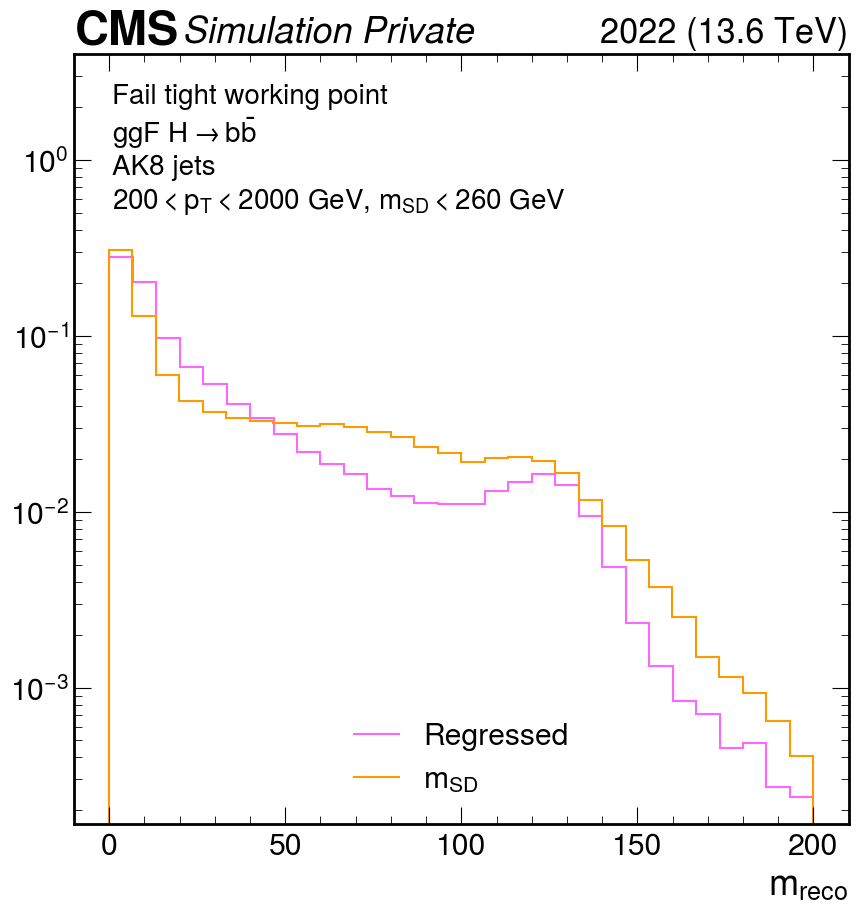

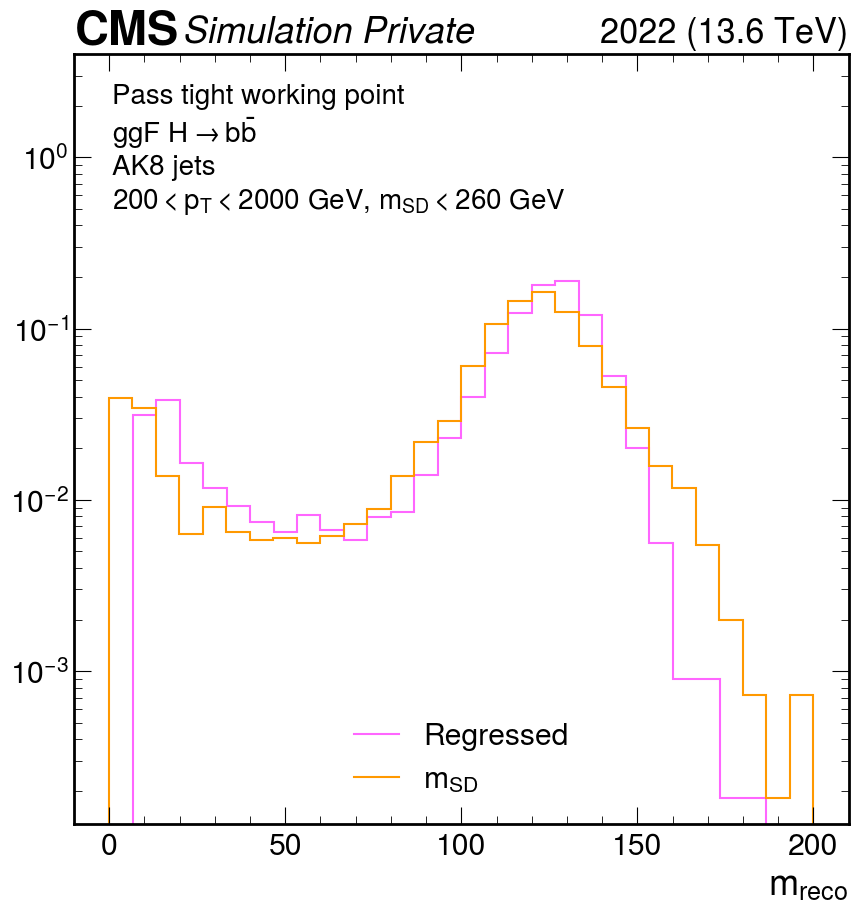

In [33]:
colours = {
    "hbb" : "#FF66FF",
    "qcd" : "#FF9900",
}

labels = {
    1 : "loose",
    2 : "medium",
    3 : "tight",
}

wp = 3

h = output["h"]

for events, match in [(f"Fail {labels[wp]} working point", 0), (f"Pass {labels[wp]} working point", 1)]:
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    for mass in ["reg", "msd"]:

        if "Pass" in events:
            h1 = h.project(mass, "disc")[:, wp:4:sum]
        else:
            h1 = h.project(mass, "disc")[:, 0:wp:sum]
        n = h1.sum()
        h1 = h1 / n

        mplhep.histplot(h1, ax=ax,
                        label=r"$m_{SD}$" if "msd" in mass else "Regressed",
                        color=colours["qcd"] if "msd" in mass else colours["hbb"])

    
    ax.set_yscale('log')
    ax.set_xlabel(r"$m_{reco}$")
    ax.legend(loc="lower center")
    ax.set_ylim(0, 4)
              
    label = mplhep.cms.label(ax=ax, data=False, year="2022", com=13.6, label="Private")

    coffee = plt.text(0.05, 0.79, f"{events}\n" + r"ggF $H\rightarrow b\bar{b}$" + "\nAK8 jets\n" + r"$200 < p_T < 2000$ GeV, $m_{SD} < 260$ GeV",
                      fontsize=20,
                      horizontalalignment='left',
                      verticalalignment='bottom',
                      transform=ax.transAxes,
                     )
              
# fig.savefig("Disc.pdf", bbox_inches='tight', pad_inches=0.1)

/tmp/ipykernel_1186/779280753.py:39: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 10**6)
/tmp/ipykernel_1186/779280753.py:39: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 10**6)


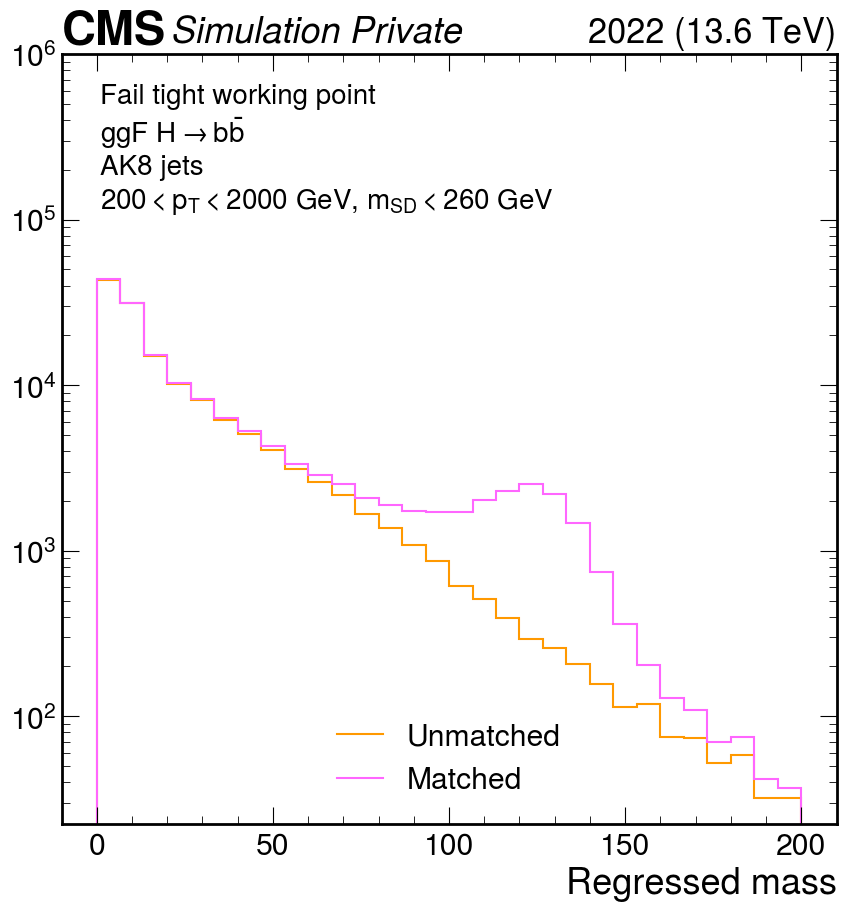

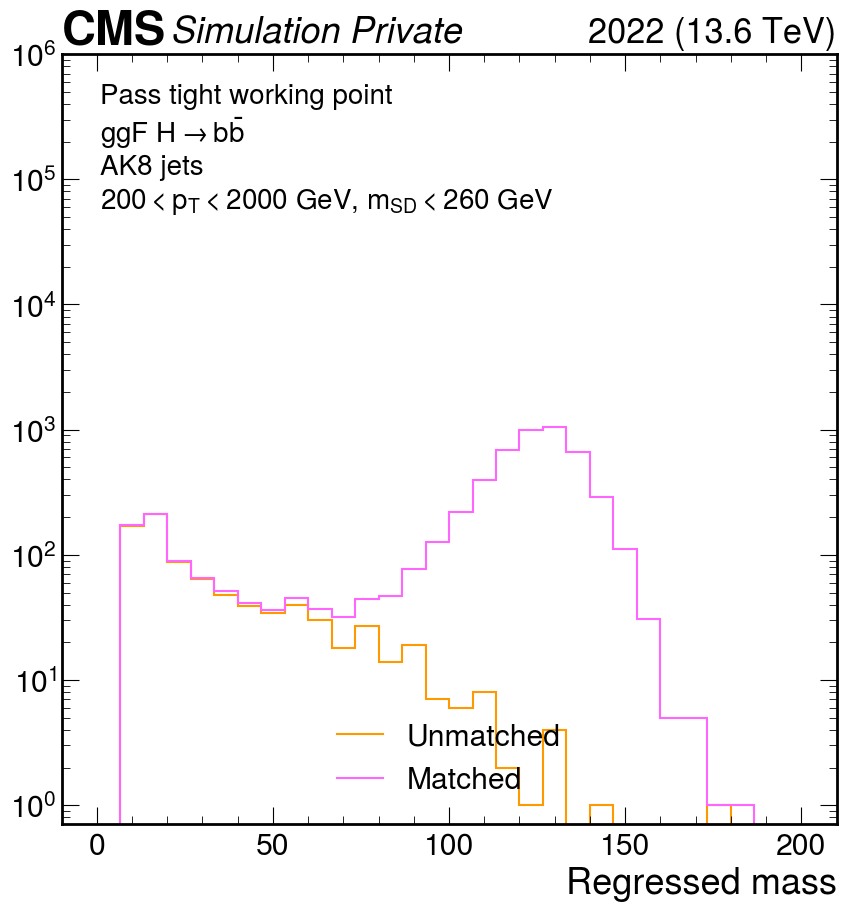

In [52]:
colours = {
    "hbb" : "#FF66FF",
    "qcd" : "#FF9900",
}

labels = {
    1 : "loose",
    2 : "medium",
    3 : "tight",
}

wp = 3

h = output["h"]

for events, match in [(f"Fail {labels[wp]} working point", 0), (f"Pass {labels[wp]} working point", 1)]:
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    for mass in ["reg"]:

        if "Pass" in events:
            h_match = h.project(mass, "match", "disc")[:, hist.loc(1), wp:4:sum]
            h_unmatch = h.project(mass, "match", "disc")[:, hist.loc(0), wp:4:sum]
        else:
            h_match = h.project(mass, "match", "disc")[:, hist.loc(1), 0:wp:sum]
            h_unmatch = h.project(mass, "match", "disc")[:, hist.loc(0), 0:wp:sum]

        mplhep.histplot([h_unmatch, h_match],
                        ax=ax,
                        stack=True,
                        label=["Unmatched", "Matched"],
                        color=[colours["qcd"], colours["hbb"]])

    
    ax.set_yscale('log')
    ax.set_xlabel(r"Regressed mass")
    ax.legend(loc="lower center")
    ax.set_ylim(0, 10**6)
              
    label = mplhep.cms.label(ax=ax, data=False, year="2022", com=13.6, label="Private")

    coffee = plt.text(0.05, 0.79, f"{events}\n" + r"ggF $H\rightarrow b\bar{b}$" + "\nAK8 jets\n" + r"$200 < p_T < 2000$ GeV, $m_{SD} < 260$ GeV",
                      fontsize=20,
                      horizontalalignment='left',
                      verticalalignment='bottom',
                      transform=ax.transAxes,
                     )
              
# fig.savefig("Disc.pdf", bbox_inches='tight', pad_inches=0.1)

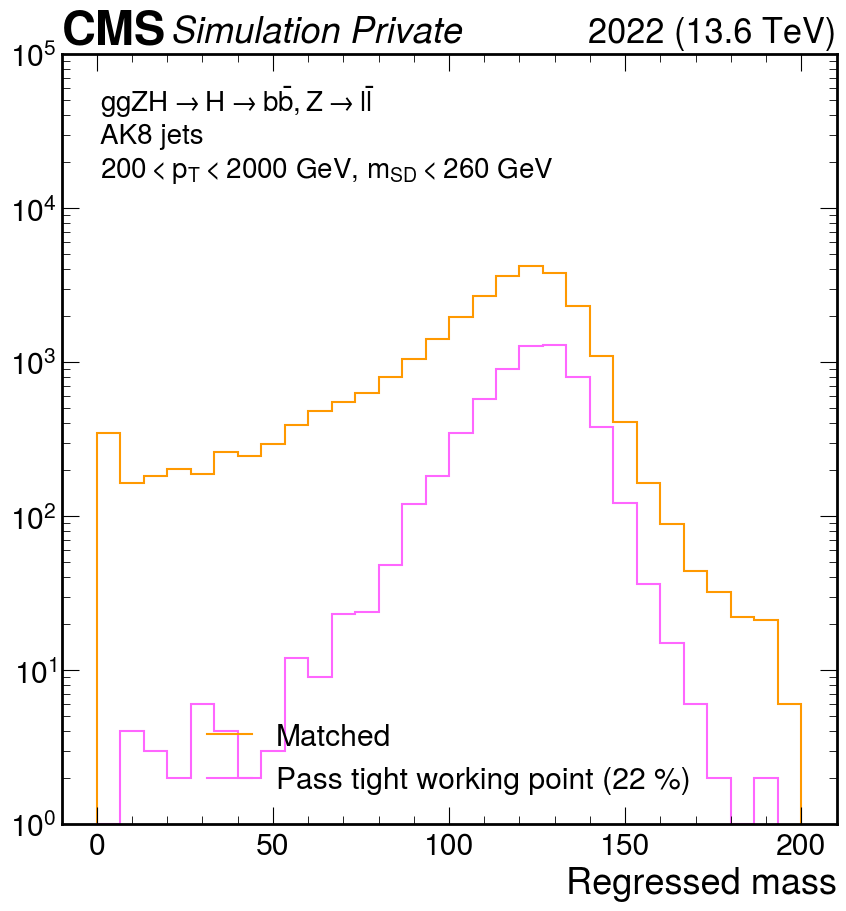

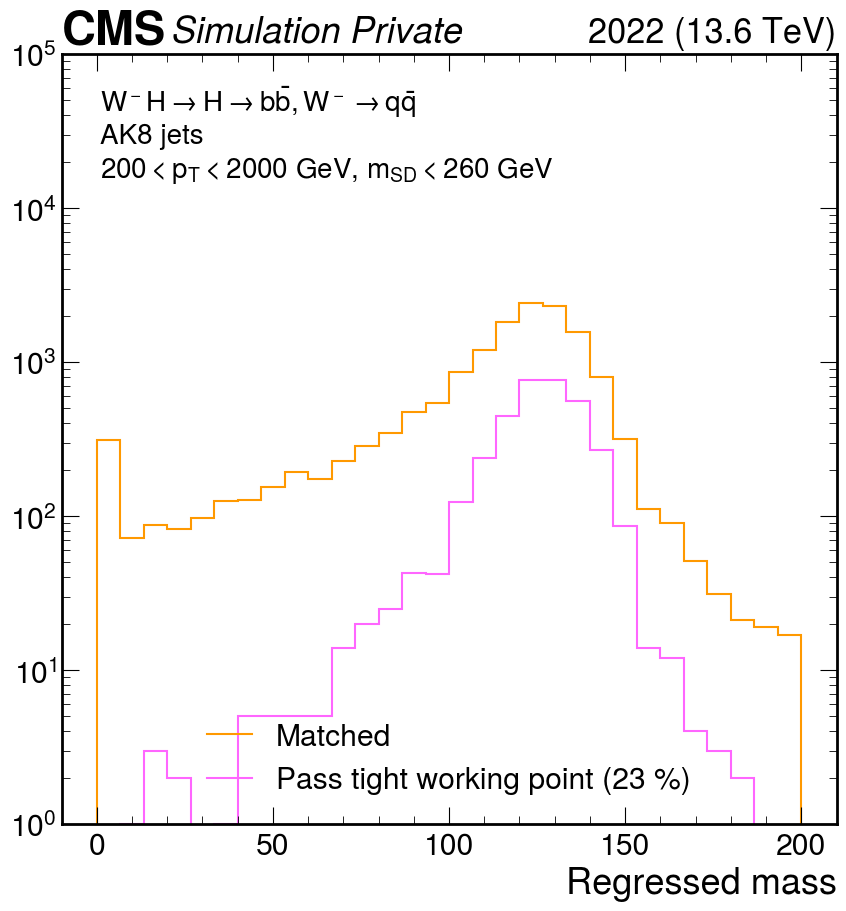

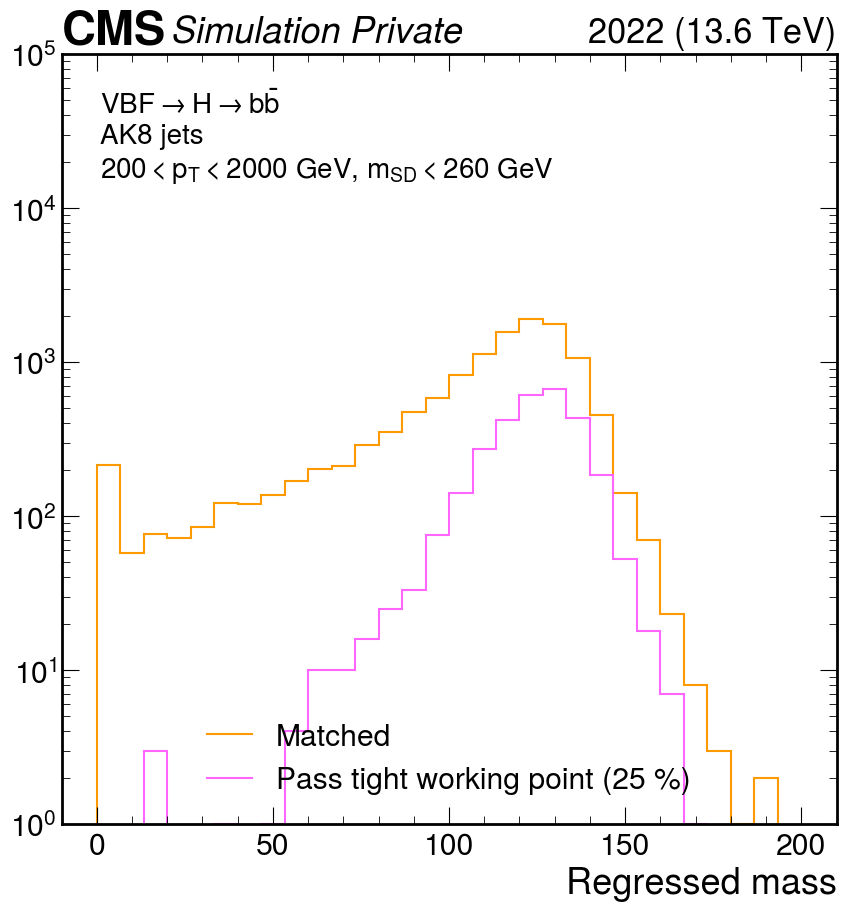

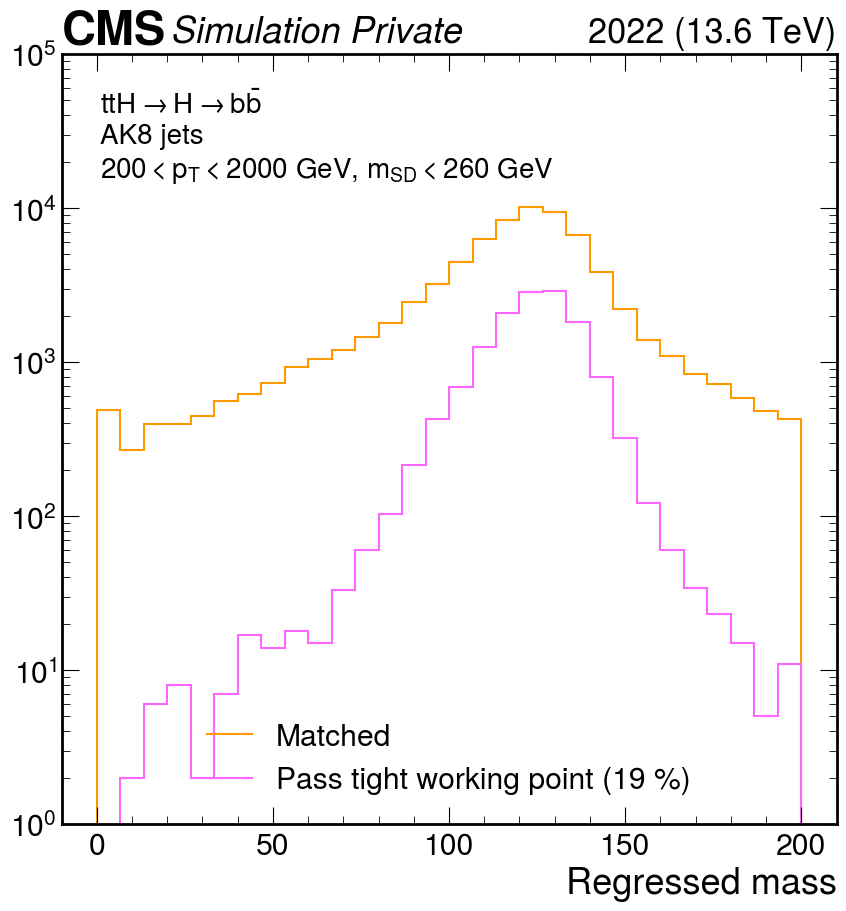

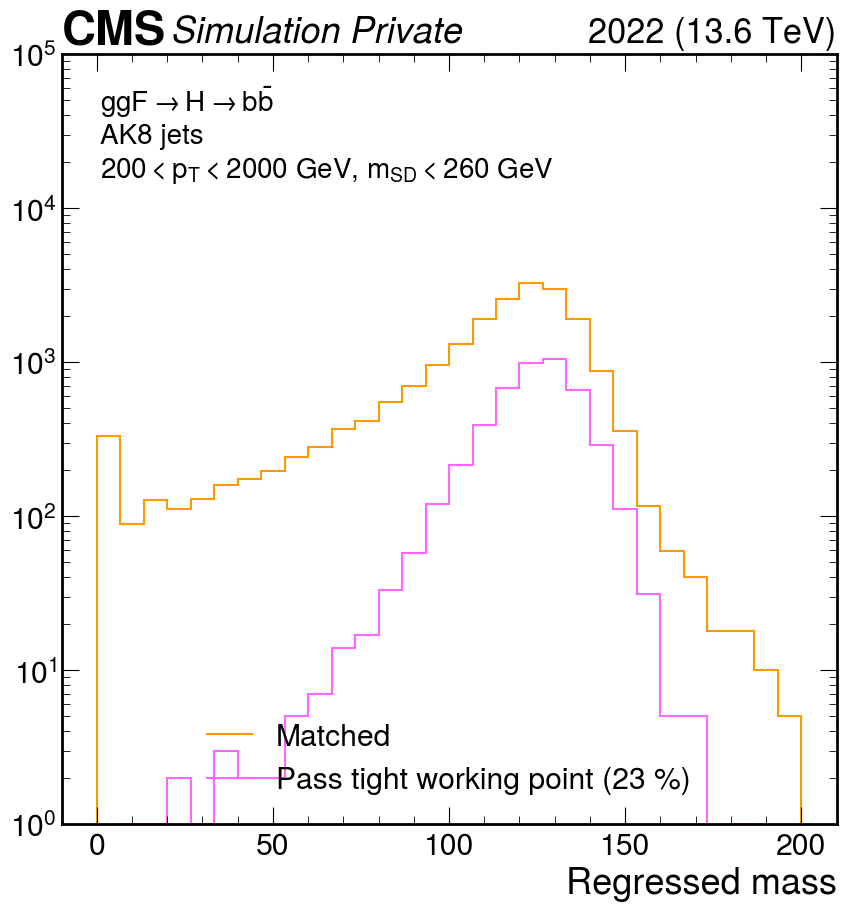

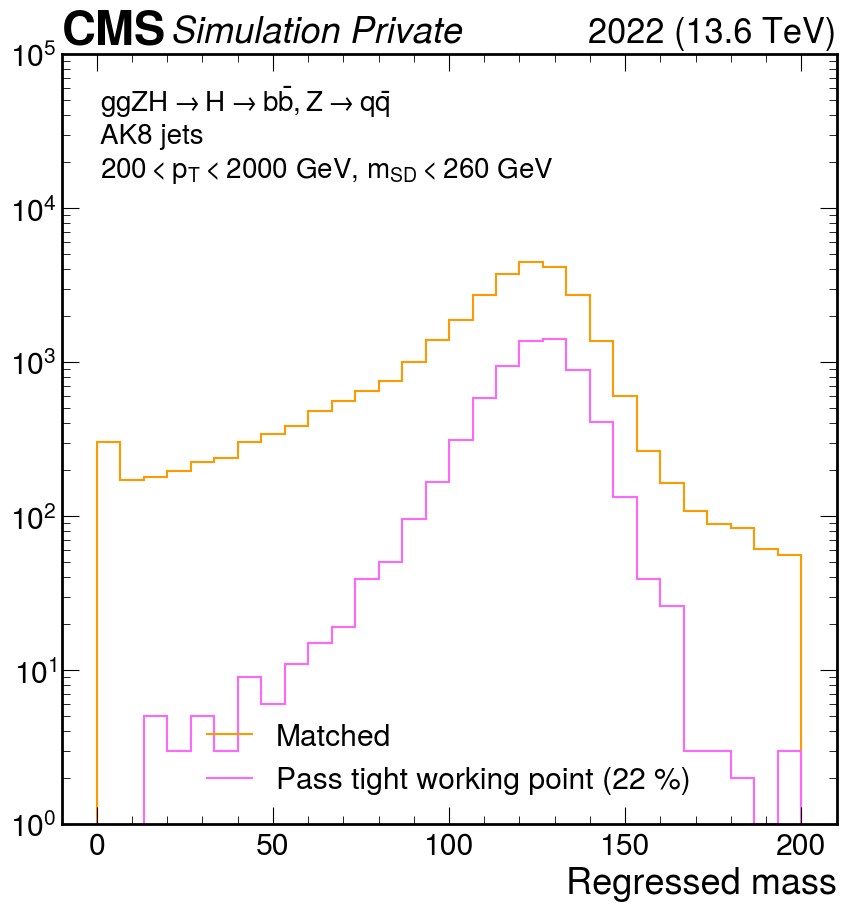

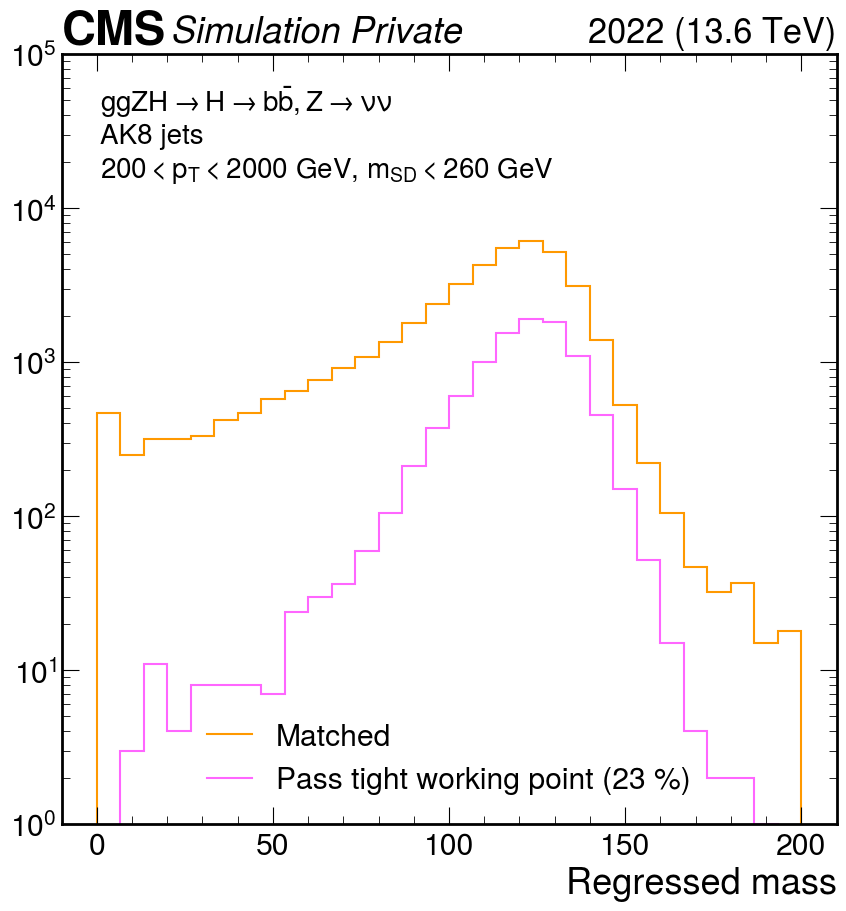

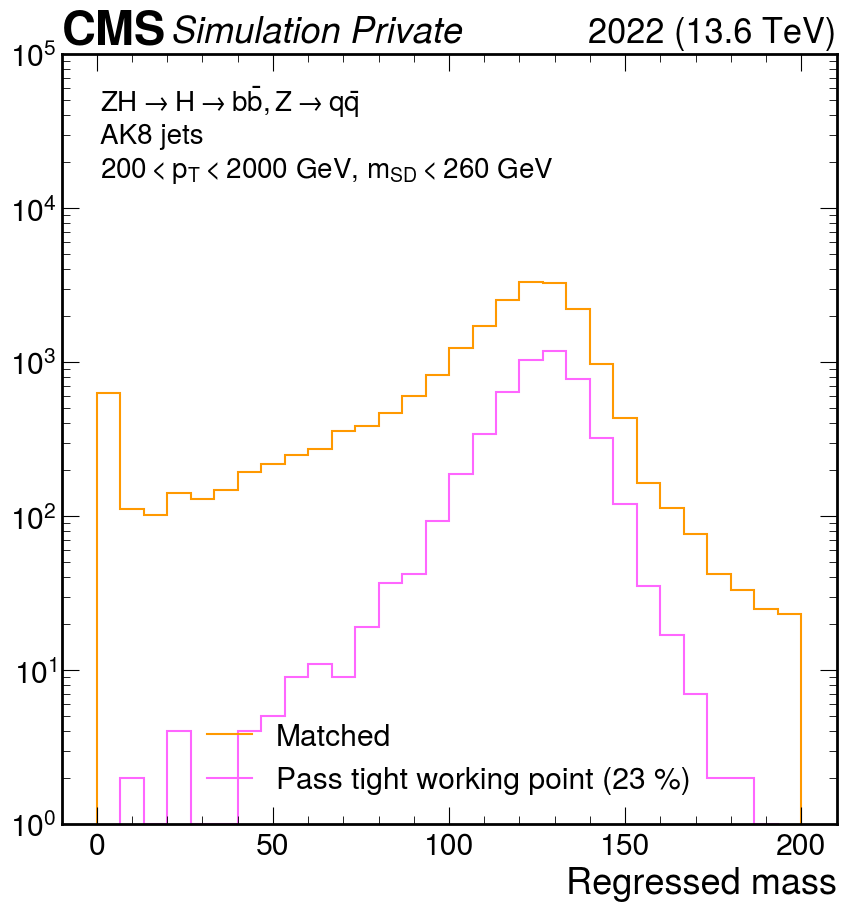

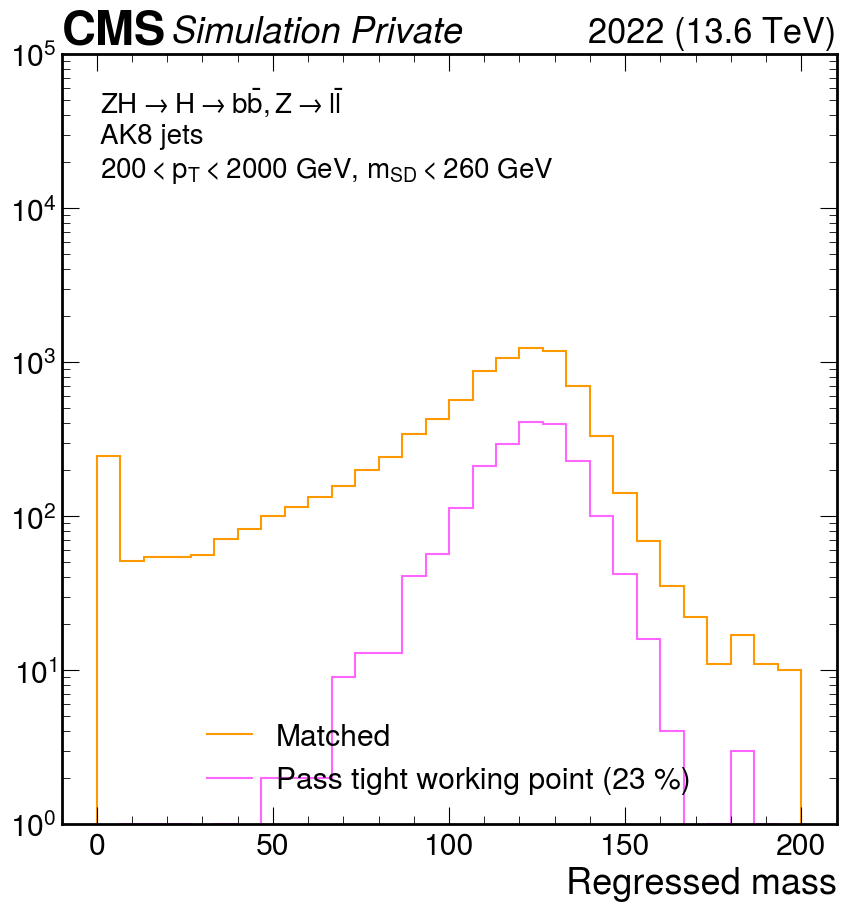

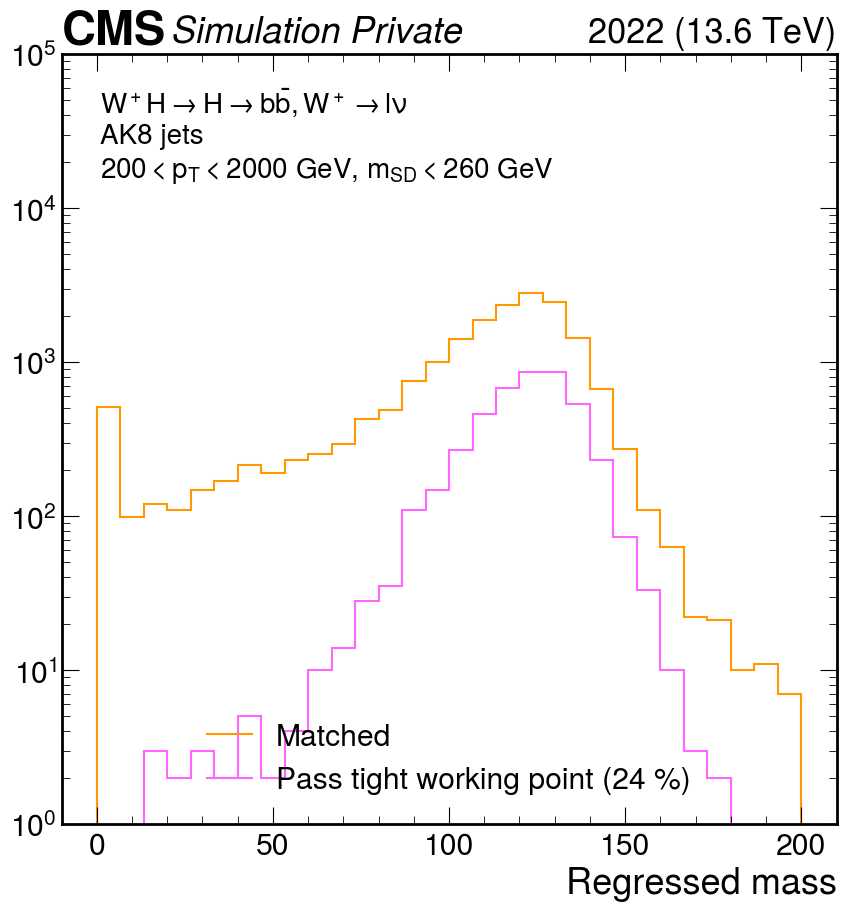

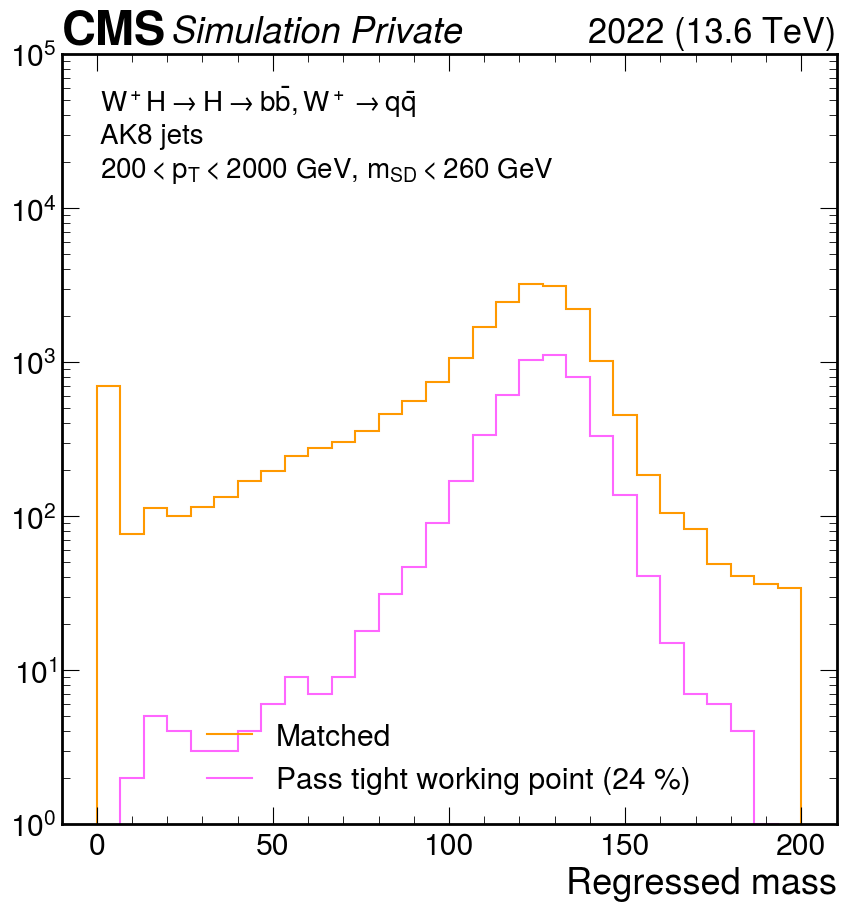

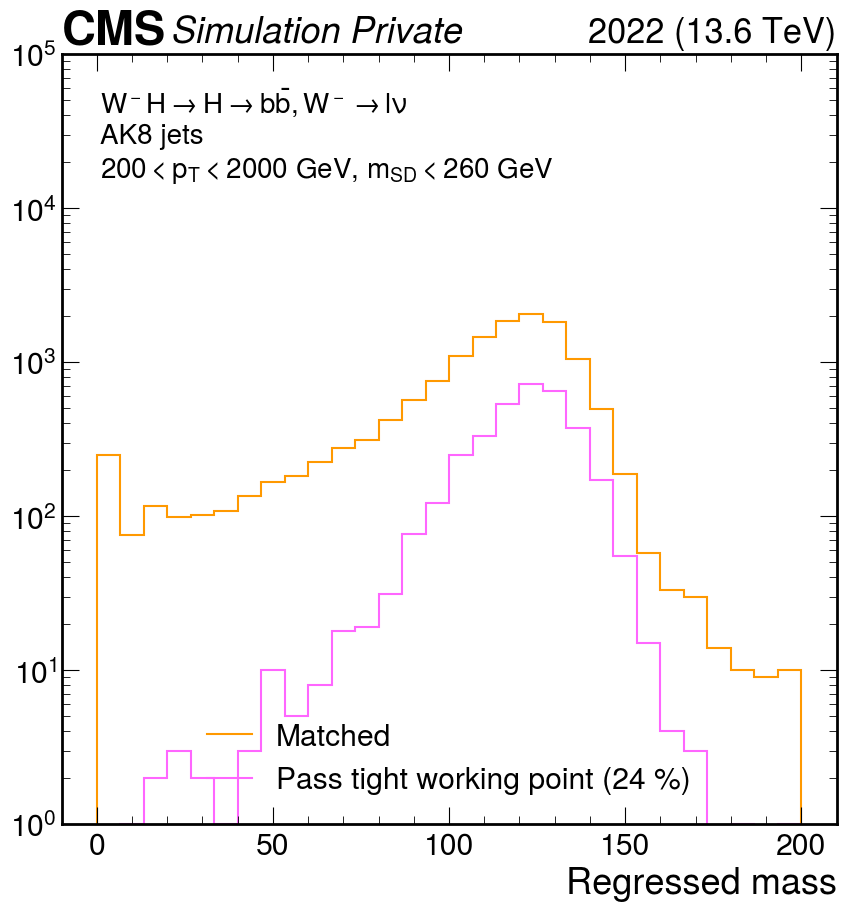

In [44]:
colours = {
    "hbb" : "#FF66FF",
    "qcd" : "#FF9900",
}

labels = {
    1 : "loose",
    2 : "medium",
    3 : "tight",
}

modes = {
    'ggZH_Hto2B_Zto2L' : r"$ggZH \rightarrow H\rightarrow b\bar{b}, Z\rightarrow l\bar{l}$",
    'WminusH_Hto2B_Wto2Q' : r"$W^-H \rightarrow H\rightarrow b\bar{b}, W^-\rightarrow q\bar{q}$",
    'VBFHTo2B' : r"$VBF \rightarrow H\rightarrow b\bar{b}$",
    'ttHto2B' : r"$ttH \rightarrow H\rightarrow b\bar{b}$",
    'GluGluHto2B' : r"$ggF \rightarrow H\rightarrow b\bar{b}$",
    'ggZh_Hto2B_Zto2Q' : r"$ggZH \rightarrow H\rightarrow b\bar{b}, Z\rightarrow q\bar{q}$",
    'ggZh_Hto2B_Zto2Nu' : r"$ggZH \rightarrow H\rightarrow b\bar{b}, Z\rightarrow \nu\nu$",
    'ZH_Hto2B_Zto2Q' : r"$ZH \rightarrow H\rightarrow b\bar{b}, Z\rightarrow q\bar{q}$",
    'ZH_Hto2B_Zto2L' : r"$ZH \rightarrow H\rightarrow b\bar{b}, Z\rightarrow l\bar{l}$",
    'WplusH_Hto2B_WtoLNu' : r"$W^+H \rightarrow H\rightarrow b\bar{b}, W^+\rightarrow l\nu$",
    'WplusH_Hto2B_Wto2Q' : r"$W^+H \rightarrow H\rightarrow b\bar{b}, W^+\rightarrow q\bar{q}$",
    'WminusH_Hto2B_WtoLNu' : r"$W^-H \rightarrow H\rightarrow b\bar{b}, W^-\rightarrow l\nu$"
}

wp = 3
datasets = list(output["nevents"].keys())
h = output["h"]

for dataset in datasets:

    for events, match in [(f"Pass {labels[wp]} working point", 1)]:

        fig, ax = plt.subplots(figsize=(10, 10))

        for mass in ["reg"]:

            h_all = h.project(mass, "dataset", "match")[:, hist.loc(dataset), hist.loc(1)]

            if "Pass" in events:
                h_criteria = h.project(mass, "dataset", "match", "disc")[:, hist.loc(dataset), hist.loc(1), wp:4:sum]
            else:
                h_criteria = h.project(mass, "dataset", "match", "disc")[:, hist.loc(dataset), hist.loc(1), 0:wp:sum]

            eff = h_criteria.sum() / h_all.sum()

            mplhep.histplot(h_all,
                            ax=ax,
                            stack=True,
                            label="Matched",
                            color=colours["qcd"])

            mplhep.histplot(h_criteria,
                            ax=ax,
                            stack=True,
                            label=f"{events} ({eff*100:.0f} %)",
                            color=colours["hbb"])


        ax.set_yscale('log')
        ax.set_xlabel(r"Regressed mass")
        ax.legend(loc="lower center")
        ax.set_ylim(1, 10**5)

        label = mplhep.cms.label(ax=ax, data=False, year="2022", com=13.6, label="Private")

        coffee = plt.text(0.05, 0.83, modes[dataset] + "\nAK8 jets\n" + r"$200 < p_T < 2000$ GeV, $m_{SD} < 260$ GeV",
                          fontsize=20,
                          horizontalalignment='left',
                          verticalalignment='bottom',
                          transform=ax.transAxes,
                         )
              
# fig.savefig("Disc.pdf", bbox_inches='tight', pad_inches=0.1)

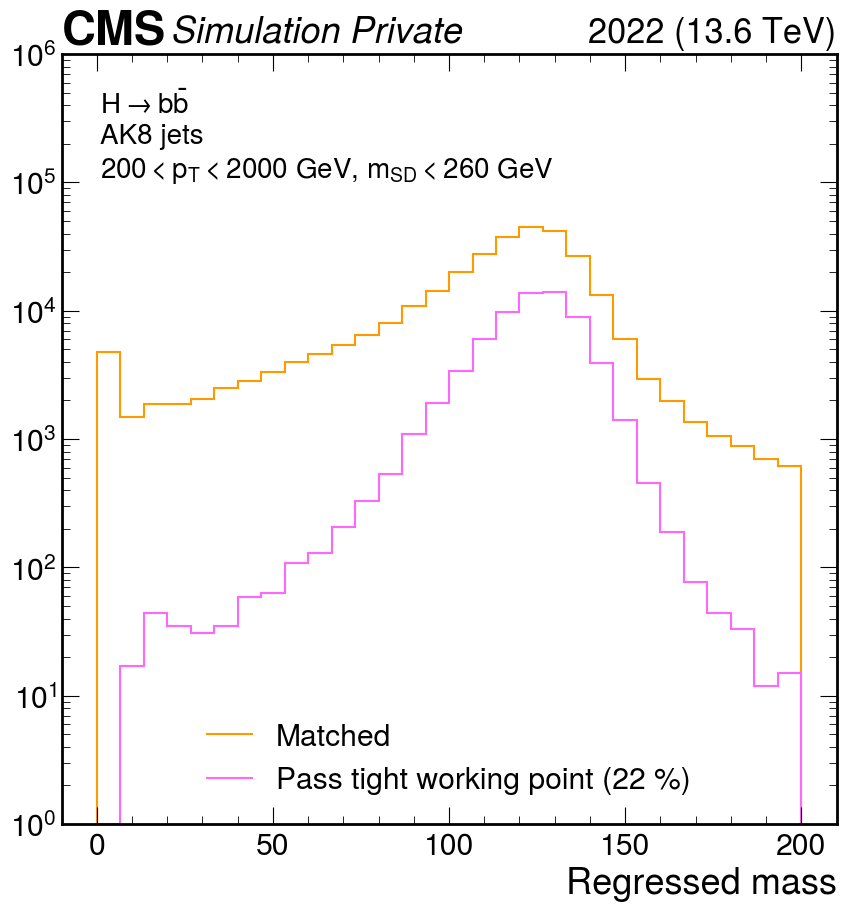

In [73]:
colours = {
    "hbb" : "#FF66FF",
    "qcd" : "#FF9900",
}

labels = {
    1 : "loose",
    2 : "medium",
    3 : "tight",
}

wp = 3
datasets = list(output["nevents"].keys())
h = output["h"]
pt1, pt2 = 200, 2000

for events, match in [(f"Pass {labels[wp]} working point", 1)]:

    fig, ax = plt.subplots(figsize=(10, 10))

    for mass in ["reg"]:

        h_base = h.project(mass, "dataset", "match", "disc", "pt")[:, sum, hist.loc(1), :,
                                                                  hist.loc(pt1):hist.loc(pt2):sum]
        h_all = h_base[:, sum]

        if "Pass" in events:
            h_criteria = h_base[:, wp:4:sum]
        else:
            h_criteria = h._base[:, 0:wp:sum]

        eff = h_criteria.sum() / h_all.sum()
        effs.append(eff)

        mplhep.histplot(h_all,
                        ax=ax,
                        stack=True,
                        label="Matched",
                        color=colours["qcd"])

        mplhep.histplot(h_criteria,
                        ax=ax,
                        stack=True,
                        label=f"{events} ({eff*100:.0f} %)",
                        color=colours["hbb"])


    ax.set_yscale('log')
    ax.set_xlabel(r"Regressed mass")
    ax.legend(loc="lower center")
    ax.set_ylim(1, 10**6)

    label = mplhep.cms.label(ax=ax, data=False, year="2022", com=13.6, label="Private")

    coffee = plt.text(0.05, 0.83, r"$H\rightarrow b\bar{b}$" + "\nAK8 jets\n" + r"$200 < p_T < 2000$ GeV, $m_{SD} < 260$ GeV",
                      fontsize=20,
                      horizontalalignment='left',
                      verticalalignment='bottom',
                      transform=ax.transAxes,
                     )

# fig.savefig("Disc.pdf", bbox_inches='tight', pad_inches=0.1)

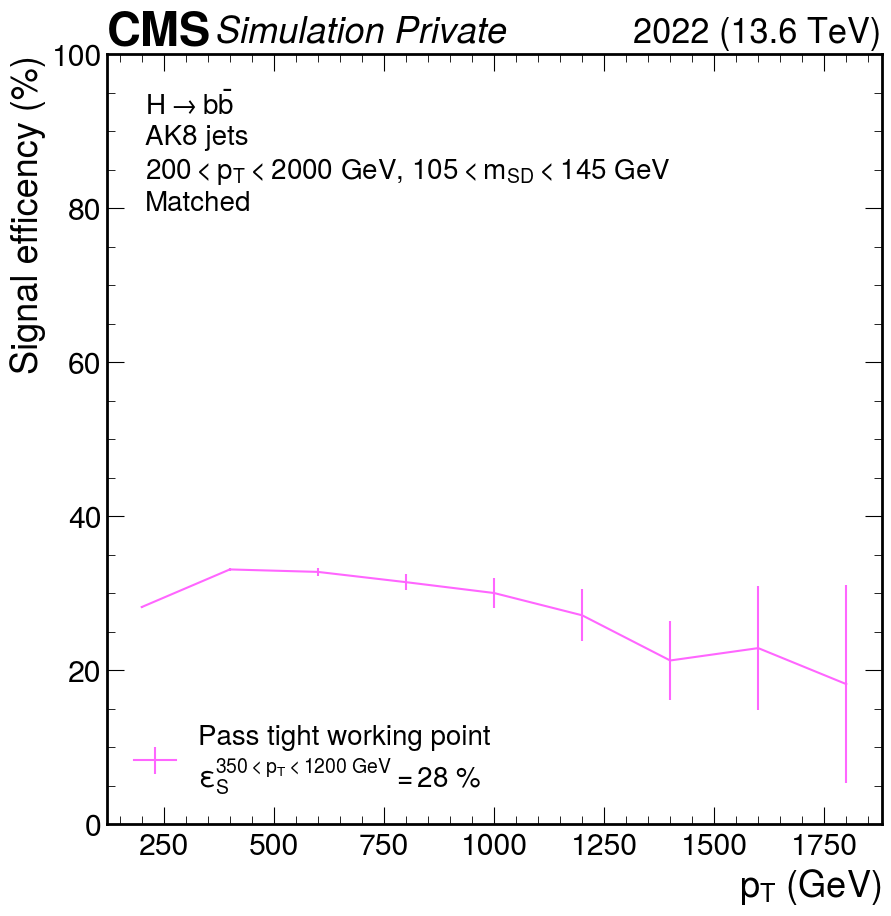

In [18]:
colours = {
    "hbb" : "#FF66FF",
    "qcd" : "#FF9900",
}

labels = {
    1 : "loose",
    2 : "medium",
    3 : "tight",
}

wp = 3
datasets = list(output["nevents"].keys())
h = output["h"]
pt1, pt2 = 400, 2000
pts = range(200, 2000, 200)
effs = []
N = []

for pt1 in pts:

    for events, match in [(f"Pass {labels[wp]} working point", 1)]:

        for mass in ["reg"]:

            h_base = h.project(mass, "dataset", "match", "disc", "pt")[hist.loc(105):hist.loc(145):sum, 
                                                                      sum, hist.loc(1), :,
                                                                      hist.loc(pt1):hist.loc(pt2):sum]
            h_all = h_base[sum]

            if "Pass" in events:
                h_criteria = h_base[wp:4:sum]
            else:
                h_criteria = h._base[0:wp:sum]

            eff = h_criteria / h_all
            effs.append(eff*100)
            N.append(h_criteria)
            
h_base = h.project("dataset", "match", "disc", "pt", mass)[sum, hist.loc(1), :,
                                                           hist.loc(350):hist.loc(1200):sum,
                                                           hist.loc(105):hist.loc(145):sum,
                                                          ]
h_all_window = h_base[sum]
h_critera_window = h_base[wp:4:sum]
eff_window = 100 * h_critera_window/h_all_window

fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(pts, effs, yerr=[e/np.sqrt(n) for e, n in zip(effs, N)], color=colours["hbb"], label=events + "\n"
            + r"$\epsilon_S^{350 < p_T < 1200~GeV}=$" + f"{eff_window:.0f} %"
           )

ax.legend(loc="lower left", fontsize=20)
ax.set_xlabel(r"$p_T$ (GeV)")
ax.set_ylabel("Signal efficency (%)")
ax.set_ylim(0, 100)

label = mplhep.cms.label(ax=ax, data=False, year="2022", com=13.6, label="Private")

coffee = plt.text(0.05, 0.79, r"$H\rightarrow b\bar{b}$" + "\nAK8 jets\n" + r"$200 < p_T < 2000$ GeV, $105 < m_{SD} < 145$ GeV" + "\nMatched",
                  fontsize=20,
                  horizontalalignment='left',
                  verticalalignment='bottom',
                  transform=ax.transAxes,
                 )
        
        
# fig.savefig("Disc.pdf", bbox_inches='tight', pad_inches=0.1)

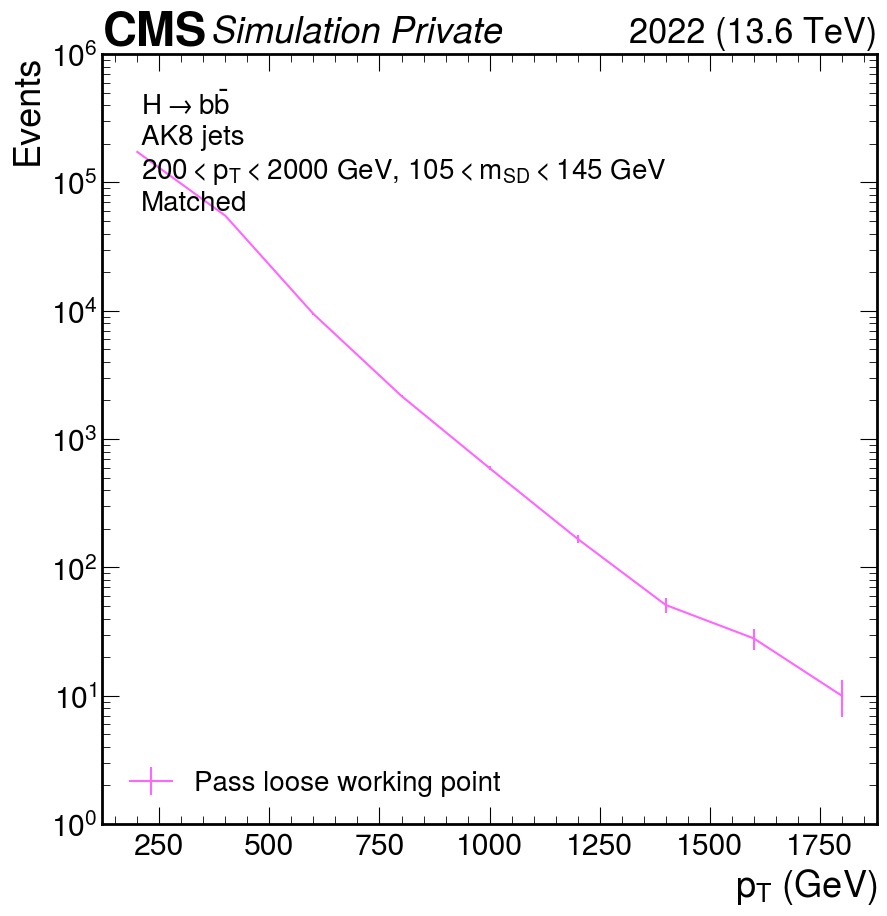

In [23]:
colours = {
    "hbb" : "#FF66FF",
    "qcd" : "#FF9900",
}

labels = {
    1 : "loose",
    2 : "medium",
    3 : "tight",
}

wp = 1
datasets = list(output["nevents"].keys())
h = output["h"]
pt1, pt2 = 400, 2000
pts = range(200, 2000, 200)
N = []

for pt1 in pts:

    for events, match in [(f"Pass {labels[wp]} working point", 1)]:

        for mass in ["reg"]:

            h_base = h.project(mass, "dataset", "match", "disc", "pt")[hist.loc(105):hist.loc(145):sum, 
                                                                      sum, hist.loc(1), :,
                                                                      hist.loc(pt1):hist.loc(pt2):sum]
            h_all = h_base[sum]

            if "Pass" in events:
                h_criteria = h_base[wp:4:sum]
            else:
                h_criteria = h._base[0:wp:sum]

            N.append(h_criteria)


fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(pts, N, yerr=[np.sqrt(n) for n in N], color=colours["hbb"], label=events)

ax.legend(loc="lower left", fontsize=20)
ax.set_xlabel(r"$p_T$ (GeV)")
ax.set_ylabel("Events")
ax.set_yscale('log')
ax.set_ylim(1, 10**6)

label = mplhep.cms.label(ax=ax, data=False, year="2022", com=13.6, label="Private")

coffee = plt.text(0.05, 0.79, r"$H\rightarrow b\bar{b}$" + "\nAK8 jets\n" + r"$200 < p_T < 2000$ GeV, $105 < m_{SD} < 145$ GeV" + "\nMatched",
                  fontsize=20,
                  horizontalalignment='left',
                  verticalalignment='bottom',
                  transform=ax.transAxes,
                 )
        
        
# fig.savefig("Disc.pdf", bbox_inches='tight', pad_inches=0.1)

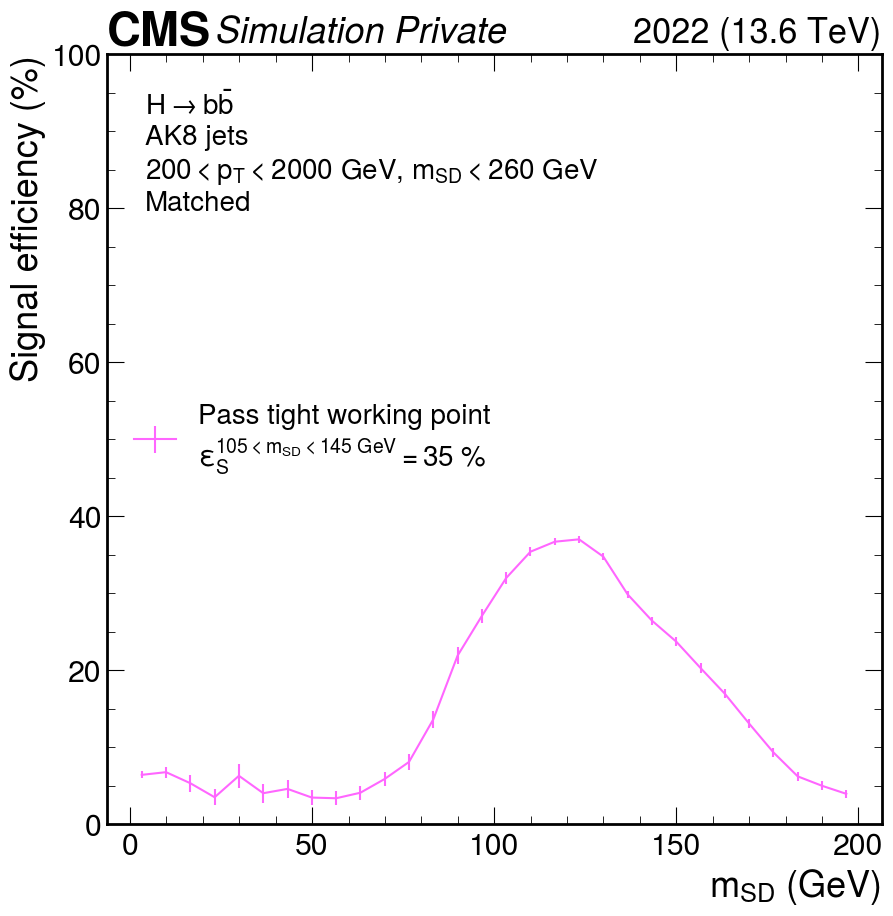

In [13]:
colours = {
    "hbb" : "#FF66FF",
    "qcd" : "#FF9900",
}

labels = {
    1 : "loose",
    2 : "medium",
    3 : "tight",
}

wp = 3
mass = "msd"
datasets = list(output["nevents"].keys())
h = output["h"][:, hist.rebin(1), :, :, :, :]
centers = h.project(mass).axes[0].centers
edges = h.project(mass).axes[0].edges
effs = []
N = []

for i, _ in enumerate(centers):

    for events, match in [(f"Pass {labels[wp]} working point", 1)]:

        h_base = h.project("dataset", "match", "disc", "pt", mass)[sum, hist.loc(1), :, hist.loc(350):hist.loc(2000):sum,
                                                             i:i+1:sum]
        h_all = h_base[sum]

        if "Pass" in events:
            h_criteria = h_base[wp:4:sum]
        else:
            h_criteria = h_base[0:wp:sum]

        eff = h_criteria / h_all
        effs.append(eff*100)
        N.append(h_criteria)

h_base = h.project("dataset", "match", "disc", "pt", mass)[sum, hist.loc(1), :,
                                                           hist.loc(350):hist.loc(2000):sum,
                                                           hist.loc(105):hist.loc(145):sum,
                                                          ]
h_all_window = h_base[sum]
h_critera_window = h_base[wp:4:sum]
eff_window = 100 * h_critera_window/h_all_window
        
fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(centers, effs, yerr=[e/np.sqrt(n) for e, n in zip(effs, N)],
            color=colours["hbb"], label=events + "\n"
            + r"$\epsilon_S^{105 < m_{SD} < 145~GeV}=$" + f"{eff_window:.0f} %"
           )

ax.legend(loc="center left", fontsize=20)
ax.set_xlabel(r"$m_{SD}$ (GeV)")
ax.set_ylim(0, 100)
ax.set_ylabel("Signal efficiency (%)")

label = mplhep.cms.label(ax=ax, data=False, year="2022", com=13.6, label="Private")

coffee = plt.text(0.05, 0.79, r"$H\rightarrow b\bar{b}$" + "\nAK8 jets\n" + r"$200 < p_T < 2000$ GeV, $m_{SD} < 260$ GeV" + "\nMatched",
                  fontsize=20,
                  horizontalalignment='left',
                  verticalalignment='bottom',
                  transform=ax.transAxes,
                 )
        
        
# fig.savefig("Disc.pdf", bbox_inches='tight', pad_inches=0.1)

# QCD <a class="anchor" id="qcd"></a>

In [84]:
from coffea.nanoevents import NanoEventsFactory, ScoutingNanoAODSchema, ScoutingJMENanoAODSchema
from coffea import processor, util
from collections import defaultdict

from processors.helper import (
    add_pileup_weight,
)

class Processor(processor.ProcessorABC):
    def __init__(self):
        pass

    def process(self, events):
        
        dataset = events.metadata['dataset']
        output = defaultdict()
        
        h = Hist(
            hist.axis.Variable([-0.1, 0.8167194, 0.95448214, 0.9864132, 1.1], name="disc", label=r"$H\rightarrow b\bar{b}$ vs QCD discriminator"),
            hist.axis.Regular(30, 0, 200, name="reg", label=r"Regressed mass"),
            hist.axis.Regular(30, -0.1, 200, name="msd", label=r"$m_{SD}$"),
            hist.axis.Regular(36, 200, 2000, name="pt", label=r"$p_T"),
        )
        
        def normalise(arr):
            return ak.to_numpy(ak.fill_none(arr, np.nan))

        def hbb_disc(sig, bkg):
            return ak.where((sig + bkg == 0), 0, sig / (sig + bkg))
        
        events = events[
            (events.Pileup.nPU < 100)
        ]
        
        output["nevents"] = len(events)
        
        add_pileup_weight(events)
        
        fatjets = events.ScoutingFatJet
        fatjets['weight_pileup'] = ak.broadcast_arrays(events['weight_pileup'], fatjets.pt)[0]
        fatjets = fatjets[
            (fatjets.pt > 200) &
            (fatjets.pt < 2000) &
            (fatjets.msoftdrop < 260)
        ]
        fatjet = ak.firsts(fatjets)
        
        disc = hbb_disc(
            fatjet.particleNet_prob_Hbb,
            fatjet.particleNet_prob_QCD
        )

        h.fill(
            disc = normalise(disc),
            msd = normalise(fatjet.msoftdrop),
            reg = normalise(fatjet.particleNet_mass),
            pt = normalise(fatjet.pt),
            weight = normalise(fatjet['weight_pileup']),
        )
        
        output["h"] = h

        return output

    def postprocess(self, accumulator):
        pass

In [85]:
fileset = {}
with open(f"{json_dir}/QCD_PT_15-7000_short.json") as fin:
    fileset = json.load(fin)
    
futures_run = processor.Runner(
    executor = processor.FuturesExecutor(compression=None, workers=2),
    schema=ScoutingNanoAODSchema,
)

output = futures_run(
    fileset,
    "Events",
    processor_instance=Processor()
)

util.save(output, "outfiles/2022/tagger/tagger_and_massreg_QCD_PT_15-7000.coffea")

Output()

/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(
/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(


In [25]:
output = util.load("outfiles/2022/tagger/tagger_and_massreg_QCD_PT_15-7000.coffea")

/tmp/ipykernel_1186/1695193493.py:37: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 4)
/tmp/ipykernel_1186/1695193493.py:37: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 4)


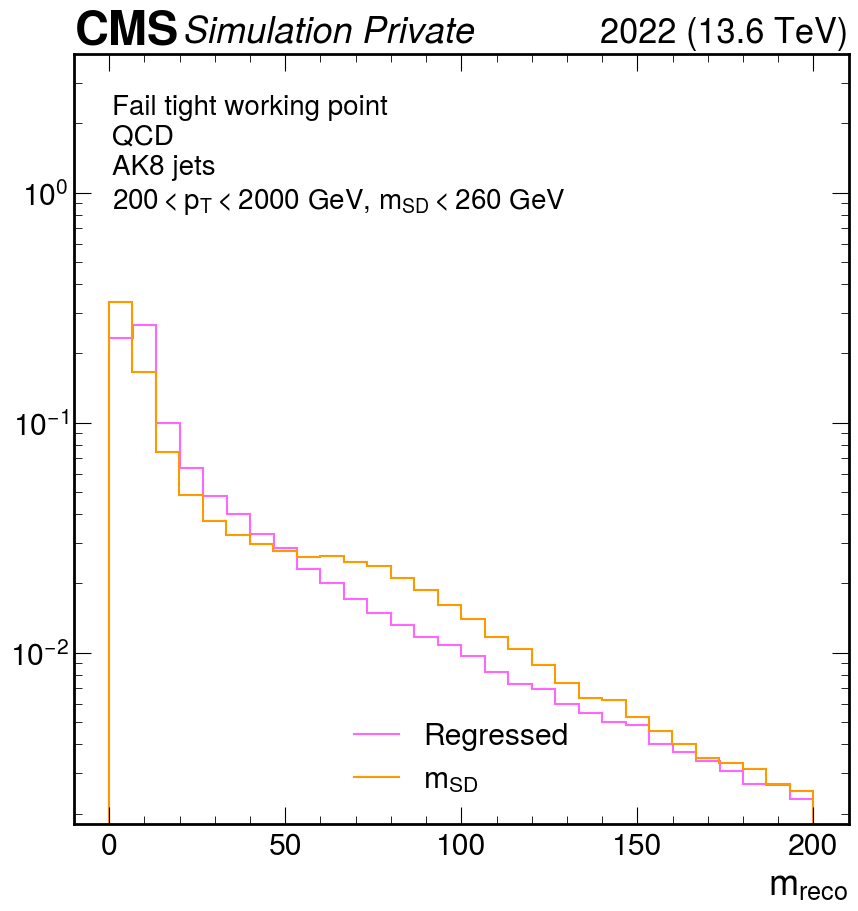

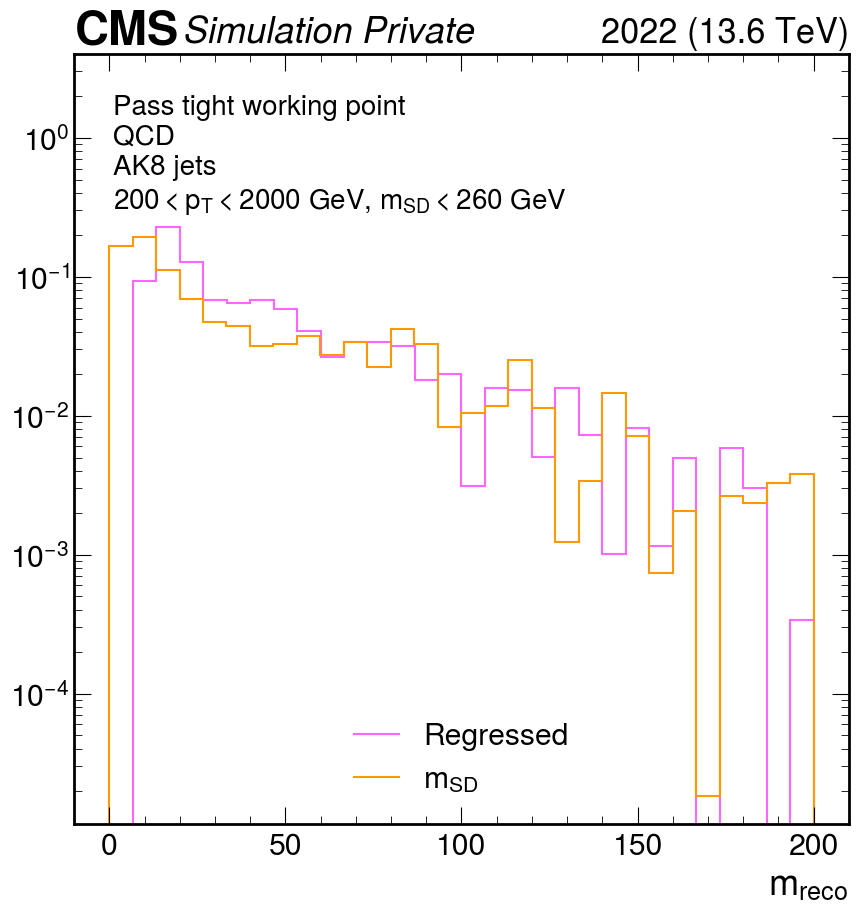

In [38]:
colours = {
    "hbb" : "#FF66FF",
    "qcd" : "#FF9900",
}

labels = {
    1 : "loose",
    2 : "medium",
    3 : "tight",
}

wp = 3

h = output["h"]

for events, match in [(f"Fail {labels[wp]} working point", 0), (f"Pass {labels[wp]} working point", 1)]:
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    for mass in ["reg", "msd"]:

        if "Pass" in events:
            h1 = h.project(mass, "disc")[:, wp:4:sum]
        else:
            h1 = h.project(mass, "disc")[:, 0:wp:sum]
        n = h1.sum()
        h1 = h1 / n

        mplhep.histplot(h1, ax=ax,
                        label=r"$m_{SD}$" if "msd" in mass else "Regressed",
                        color=colours["qcd"] if "msd" in mass else colours["hbb"])

    
    ax.set_yscale('log')
    ax.set_xlabel(r"$m_{reco}$")
    ax.legend(loc="lower center")
    ax.set_ylim(0, 4)
              
    label = mplhep.cms.label(ax=ax, data=False, year="2022", com=13.6, label="Private")

    coffee = plt.text(0.05, 0.79, f"{events}\n" + "QCD\nAK8 jets\n" + r"$200 < p_T < 2000$ GeV, $m_{SD} < 260$ GeV",
                      fontsize=20,
                      horizontalalignment='left',
                      verticalalignment='bottom',
                      transform=ax.transAxes,
                     )
              
# fig.savefig("Disc.pdf", bbox_inches='tight', pad_inches=0.1)

/tmp/ipykernel_32/1903008337.py:47: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 10**7)


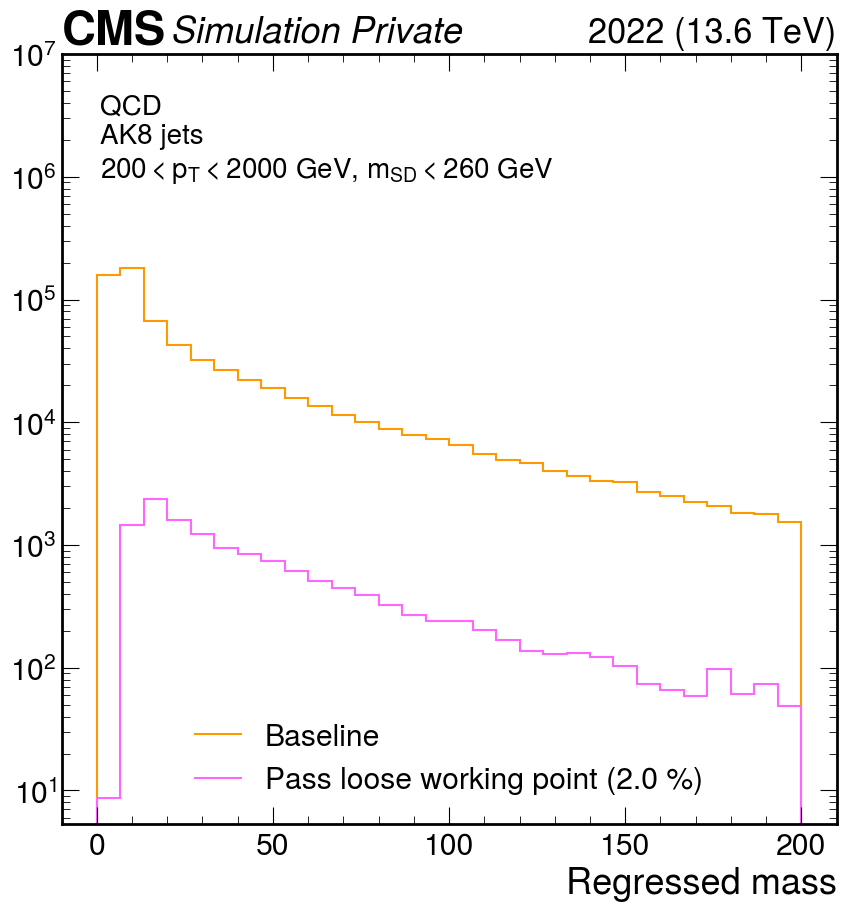

In [31]:
colours = {
    "hbb" : "#FF66FF",
    "qcd" : "#FF9900",
}

labels = {
    1 : "loose",
    2 : "medium",
    3 : "tight",
}

wp = 1

h = output["h"]

for events, match in [(f"Pass {labels[wp]} working point", 1)]:
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    for mass in ["reg"]:

        h_all = h.project(mass)
        
        if "Pass" in events:
            h_criteria = h.project(mass, "disc")[:, wp:4:sum]
        else:
            h_criteria = h.project(mass, "disc")[:, 0:wp:sum]
            
        eff = h_criteria.sum() / h_all.sum()

        mplhep.histplot(h_all,
                        ax=ax,
                        stack=True,
                        label="Baseline",
                        color=colours["qcd"])
        
        mplhep.histplot(h_criteria,
                        ax=ax,
                        stack=True,
                        label=f"{events} ({eff*100:.1f} %)",
                        color=colours["hbb"])

    
    ax.set_yscale('log')
    ax.set_xlabel(r"Regressed mass")
    ax.legend(loc="lower center")
    ax.set_ylim(0, 10**7)
              
    label = mplhep.cms.label(ax=ax, data=False, year="2022", com=13.6, label="Private")

    coffee = plt.text(0.05, 0.83, r"QCD" + "\nAK8 jets\n" + r"$200 < p_T < 2000$ GeV, $m_{SD} < 260$ GeV",
                      fontsize=20,
                      horizontalalignment='left',
                      verticalalignment='bottom',
                      transform=ax.transAxes,
                     )
              
# fig.savefig("Disc.pdf", bbox_inches='tight', pad_inches=0.1)

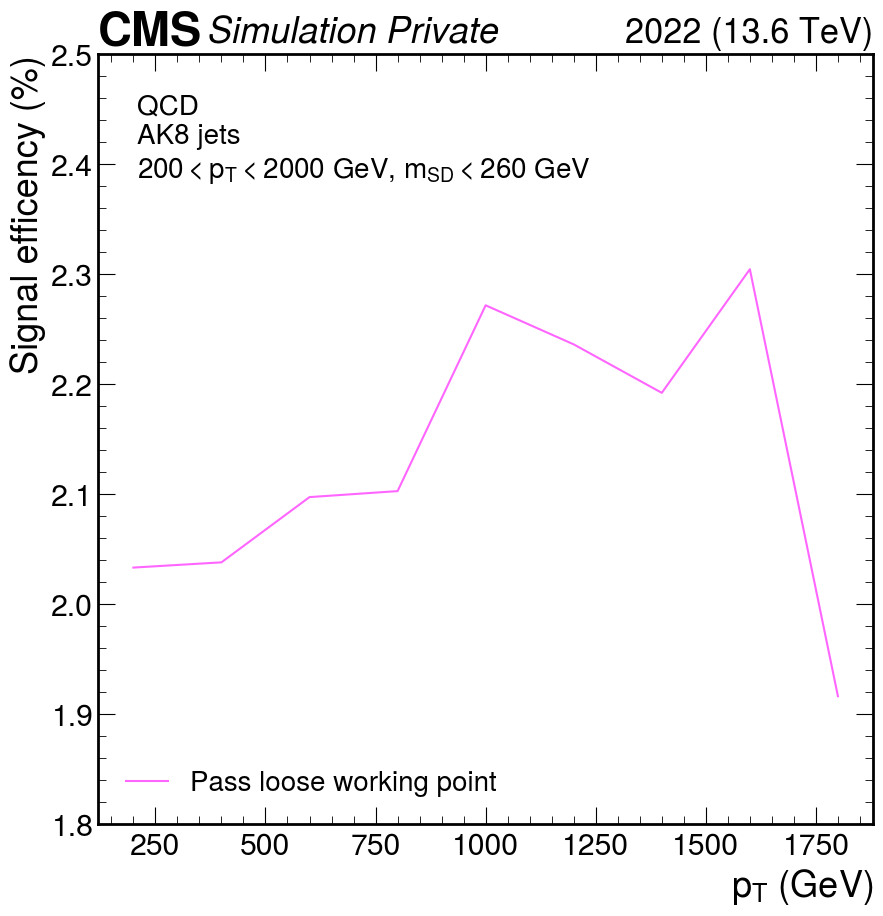

In [109]:
colours = {
    "hbb" : "#FF66FF",
    "qcd" : "#FF9900",
}

labels = {
    1 : "loose",
    2 : "medium",
    3 : "tight",
}

wp = 1
h = output["h"]
pt1, pt2 = 400, 2000
pts = range(200, 2000, 200)
effs = []

for pt1 in pts:

    for events, match in [(f"Pass {labels[wp]} working point", 1)]:

        for mass in ["reg"]:

            h_base = h.project(mass, "disc", "pt")[:, :, hist.loc(pt1):hist.loc(pt2):sum]
            h_all = h_base[:, sum]

            if "Pass" in events:
                h_criteria = h_base[:, wp:4:sum]
            else:
                h_criteria = h._base[:, 0:wp:sum]

            eff = h_criteria.sum() / h_all.sum()
            effs.append(eff*100)

fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(pts, effs, color=colours["hbb"], label=events)

ax.legend(loc="lower left", fontsize=20)
ax.set_xlabel(r"$p_T$ (GeV)")
ax.set_ylabel("Signal efficency (%)")
ax.set_ylim(1.8, 2.5)

label = mplhep.cms.label(ax=ax, data=False, year="2022", com=13.6, label="Private")

coffee = plt.text(0.05, 0.83, r"QCD" + "\nAK8 jets\n" + r"$200 < p_T < 2000$ GeV, $m_{SD} < 260$ GeV",
                  fontsize=20,
                  horizontalalignment='left',
                  verticalalignment='bottom',
                  transform=ax.transAxes,
                 )
        
        
# fig.savefig("Disc.pdf", bbox_inches='tight', pad_inches=0.1)